In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import pandas as pd
import numpy as np
import math
import re
import random
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WhitespaceTokenizer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Bidirectional
from keras.layers import Dropout
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/updated_dataset.csv')

# Vectorization

In [ ]:
dataset = df
unique_label = np.unique(df["target"])
num_classes = len(unique_label)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset['review'].values, pd.get_dummies(dataset['target']).values, test_size=0.50)

MAX_NB_WORDS = 120811
MAX_SEQUENCE_LENGTH = 2000
EMBEDDING_DIM = 250

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)
word_index = tokenizer.word_index
print("found ", len(word_index), " unique tokens")

train_seq = tokenizer.texts_to_sequences(X_train)
test_seq = tokenizer.texts_to_sequences(X_test)
pad_train = pad_sequences(train_seq, maxlen=MAX_SEQUENCE_LENGTH)
pad_test = pad_sequences(test_seq, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', pad_train.shape)

print(pad_train.shape,y_train.shape)
print(pad_test.shape,y_test.shape)

found  120811  unique tokens
Shape of data tensor: (25000, 2000)
(25000, 2000) (25000, 2)
(25000, 2000) (25000, 2)


# Model_BI-LSTM

In [ ]:
from keras import layers
model_1 = Sequential()
model_1.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=pad_train.shape[1]))
model_1.add(layers.Bidirectional(layers.LSTM(250, activation= 'tanh', dropout = 0.5)))
model_1.add(Dense(2, activation='sigmoid'))


model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
model_1.summary()

epochs = 20
batch_size = 128

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 2000, 250)         30202750  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 500)               1002000   
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1002      
Total params: 31,205,752
Trainable params: 31,205,752
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model_1.fit(pad_train, y_train, epochs=epochs, batch_size=batch_size,validation_data=(pad_test, y_test))

Epoch 1/20
196/196 [==============================] - 426s 2s/step - loss: 0.4438 - accuracy: 0.7904 - val_loss: 0.3065 - val_accuracy: 0.8756
Epoch 2/20
196/196 [==============================] - 419s 2s/step - loss: 0.2125 - accuracy: 0.9221 - val_loss: 0.3231 - val_accuracy: 0.8700
Epoch 3/20
196/196 [==============================] - 418s 2s/step - loss: 0.1127 - accuracy: 0.9616 - val_loss: 0.3251 - val_accuracy: 0.8816
Epoch 4/20
196/196 [==============================] - 419s 2s/step - loss: 0.0650 - accuracy: 0.9788 - val_loss: 0.4340 - val_accuracy: 0.8700
Epoch 5/20
196/196 [==============================] - 419s 2s/step - loss: 0.0447 - accuracy: 0.9861 - val_loss: 0.4451 - val_accuracy: 0.8682
Epoch 6/20
196/196 [==============================] - 422s 2s/step - loss: 0.0276 - accuracy: 0.9919 - val_loss: 0.4714 - val_accuracy: 0.8696
Epoch 7/20
196/196 [==============================] - 422s 2s/step - loss: 0.0186 - accuracy: 0.9953 - val_loss: 0.5897 - val_accuracy: 0.8685

In [ ]:
evaluation = model_1.evaluate(pad_test,y_test)
accuracy = evaluation[1] * 100
print("Accuracy is : ", accuracy)

782/782 [==============================] - 239s 305ms/step - loss: 0.9284 - accuracy: 0.8659
Accuracy is :  86.59200072288513


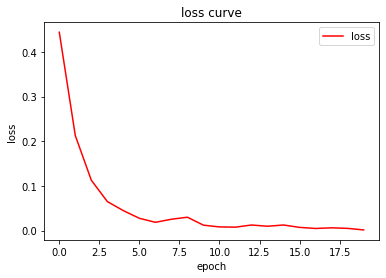

In [ ]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], color='r')
# pyplot.plot(history.history['val_loss'], color='b')
pyplot.title('loss curve')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['loss', 'val_loss'], loc='upper right')
pyplot.show()

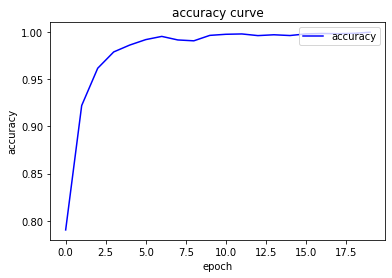

In [ ]:
from matplotlib import pyplot

pyplot.plot(history.history['accuracy'], color='b')
# pyplot.plot(history.history['val_accuracy'], color='b')
pyplot.title('accuracy curve')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['accuracy', 'val_accuracy'], loc='upper right')
pyplot.show()

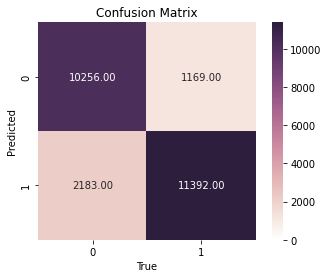

In [ ]:
y_pred = model_1.predict(pad_test)

new_y_pred = np.argmax(y_pred, axis=1)
new_y_test = np.argmax(y_test, axis=1)

conf_arr = np.zeros((num_classes, num_classes))

for i in range(len(new_y_pred)):
        conf_arr[new_y_pred[i]][new_y_test[i]] += 1

df_cm = pd.DataFrame(conf_arr, index = unique_label, columns = unique_label)


fig = plt.figure()
plt.clf()

ax = fig.add_subplot()
ax.set_aspect(1)

cmap = sb.cubehelix_palette(light=1, as_cmap=True)
res = sb.heatmap(df_cm, annot=True, vmin=0.0, vmax=np.max(conf_arr), fmt='.2f', cmap=cmap)

plt.title('Confusion Matrix')
plt.ylabel('Predicted')
plt.xlabel('True')
plt.show()

In [ ]:
precision =   precision_score(new_y_test, new_y_pred) * 100
recall =  recall_score(new_y_test, new_y_pred) * 100
f1_score =  f1_score(new_y_test, new_y_pred) * 100
print("Precision is : ",precision)
print("Recall is : ",recall)
print("F1-score is : ",f1_score)


Precision is :  83.91896869244935
Recall is :  90.69341612928908
F1-score is :  87.17477808386901


In [ ]:
print(classification_report(new_y_test, new_y_pred))

              precision    recall  f1-score   support

           0       0.90      0.82      0.86     12439
           1       0.84      0.91      0.87     12561

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

precision =   precision_score(new_y_test, new_y_pred) * 100
recall =  recall_score(new_y_test, new_y_pred) * 100
f1_score =  f1_score(new_y_test, new_y_pred) * 100
print('Pricision = ',precision)
print('F1_score = ',f1_score)
print('Recall = ',recall)

Pricision =  83.91896869244935
F1_score =  87.17477808386901
Recall =  90.69341612928908


In [ ]:
model_1.save('/content/drive/MyDrive/Colab Notebooks/SoftComputingProject/saved_info/BiLSTM/v1')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/SoftComputingProject/saved_info/BiLSTM/v1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/SoftComputingProject/saved_info/BiLSTM/v1/assets


In [ ]:
import keras
loaded_model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/SoftComputingProject/saved_info/BiLSTM/v1')

In [ ]:
evaluation = loaded_model.evaluate(pad_test,y_test)
accuracy = evaluation[1] * 100
print("Accuracy is : ", accuracy)

782/782 [==============================] - 240s 306ms/step - loss: 0.9284 - accuracy: 0.8659
Accuracy is :  86.59200072288513


In [ ]:
np.save('/content/drive/MyDrive/Colab Notebooks/SoftComputingProject/saved_info/BiLSTM/v1/history.npy',history.history)

In [ ]:
h=np.load('/content/drive/MyDrive/Colab Notebooks/SoftComputingProject/saved_info/BiLSTM/v1/history.npy',allow_pickle='TRUE').item()

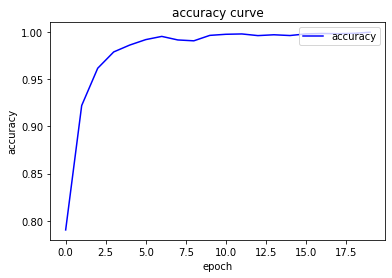

In [ ]:
from matplotlib import pyplot

pyplot.plot(h['accuracy'], color='b')
# pyplot.plot(history.history['val_accuracy'], color='b')
pyplot.title('accuracy curve')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['accuracy', 'val_accuracy'], loc='upper right')
pyplot.show()